<a href="https://colab.research.google.com/github/anilbhatt1/EVA4P1_S15B_Depth_FG_Detection/blob/master/EVA4P1_S15_FG_Depth_Prediction_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! nvidia-smi

Tue May 19 07:00:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import seaborn as sns
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
from pathlib import Path
from time import time
from datetime import datetime 
import gc
sns.set()
from zipfile import ZipFile
import zipfile

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("****apex module does not exist..hence installing*****")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

import albumentations
print(albumentations.__version__) # check version

# This is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.5"
if albumentations.__version__ != album_version_needed:
  !pip install albumentations==0.4.5   # 0.4.5 is the latest albumentation version
print('Pytorch version:', torch.__version__)

!pip install kornia
from kornia.losses import SSIM

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


0.4.5
Pytorch version: 1.5.0+cu101


In [0]:
os.mkdir('/content/sample_data/FG_BG')
os.mkdir('/content/sample_data/Mask')
os.mkdir('/content/sample_data/Depth')

FG_BG_zip =  ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_400K.zip", 'r')
Mask_zip  = ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Mask_400K.zip", 'r')
Depth_zip = ZipFile("/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Depth_400K.zip", 'r')
all_files_FG_BG = [info.filename for info in FG_BG_zip.infolist() if not info.is_dir()]
all_files_Mask  = [info.filename for info in Mask_zip.infolist() if not info.is_dir()]
all_files_Depth = [info.filename for info in Depth_zip.infolist() if not info.is_dir()]
print(len(all_files_FG_BG))
print(len(all_files_Mask))
print(len(all_files_Depth))

path_fg_bg  = '/content/sample_data/FG_BG/'
path_mask   = '/content/sample_data/Mask/' 
path_depth  = '/content/sample_data/Depth/'

t1 = time()
k = 0
for img_file in all_files_FG_BG[0:]:
    if img_file.endswith('jpg'):
        imgdata = FG_BG_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_fg_bg}{file_name}')
        k += 1
print('FG_BG Written:',k) 

k = 0
for img_file in all_files_Mask[0:]:
    if img_file.endswith('jpg'):
        imgdata = Mask_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_mask}{file_name}')
        k += 1
print('Masks Written:',k) 

k = 0
for img_file in all_files_Depth[0:]:
    if img_file.endswith('jpg'):
        imgdata = Depth_zip.read(img_file)
        img = Image.open(io.BytesIO(imgdata))
        file_name = img_file.split('/')[-1].split('.')[0] + '.jpg'
        img.save(f'{path_depth}{file_name}')
        k += 1
print('Depth Written:',k) 

!cp -r '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/BG_and_Its_Flip' '/content/sample_data/'
!cp '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/FG_BG_Filename_withflip_Logs.txt' '/content/sample_data/'

t2 = time()
print(f'Copy took {(t2-t1)/60:.5f} minutes')

400000
400000
400000
FG_BG Written: 400000
Masks Written: 400000
Depth Written: 400000
No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)

Copy took 27.09911 minutes


In [0]:
log_fg_bg = open('/content/sample_data/FG_BG_Filename_withflip_Logs.txt',"r")
content_list = log_fg_bg.readlines()
print('No: of records in log_fg_bg:',len(content_list))
print(content_list[0])
log_fg_bg.close()

data_root = Path('/content/sample_data')
f1, f2, f3 = data_root/'FG_BG', data_root/'BG_and_Its_Flip', data_root/'Mask'

No: of records in log_fg_bg: 400000
Img_fg_bg_1.jpg,Img21.jpg,Image41.png,(192, 192, 108, 156, 51, 3, 159, 3, 51, 159, 159, 159)



In [0]:
print(len(list(f1.iterdir())))
print(len(list(f2.iterdir())))
print(len(list(f3.iterdir())))

400000
210
400000


In [0]:
scale_transform = transforms.Compose([transforms.Resize((256,256)),
                                      transforms.ToTensor(),])

In [0]:
f1_files = list(f1.glob('*.jpg'))
f2_files = list(f2.glob('*.jpg'))
f3_files = list(f3.glob('*.jpg'))

In [0]:
print(len(f1_files))
print(len(f2_files))
print(len(f3_files))

400000
210
400000


In [0]:
class MasterDataset(Dataset):
  def __init__(self,data_root,content_list, transform=None):
    self.f1_files     = list(f1.glob('*.jpg'))
    self.content_list = content_list
    self.transform    = transform

  def __len__(self):
    return len(self.f1_files)  

  def __getitem__(self,index):
    fg_bg_name   = self.f1_files[index].stem
    fg_bg_idx    = fg_bg_name.split('_')[-1]
    bg_name = '/content/sample_data/BG_and_Its_Flip/' + self.content_list[int(fg_bg_idx)-1].split(',')[1]
    mask_name    = '/content/sample_data/Mask/' + 'Img_fg_bg_mask' + str(fg_bg_idx) + '.jpg'
    f1_image = Image.open(self.f1_files[index])  
    f2_image = Image.open(f'{bg_name}')
    f3_image = Image.open(f'{mask_name}')

    if self.transform:
      f1_image = self.transform(f1_image)
      f2_image = self.transform(f2_image)
      f3_image = self.transform(f3_image)

    return {'f1':f1_image, 'f2':f2_image, 'f3':f3_image}


In [0]:
mean, std = torch.tensor([0.567,0.498,0.436])*255, torch.tensor([0.384,0.309,0.256])*255

In [0]:
train_transforms = transforms.Compose([#transforms.Resize((256,256)),
                                       transforms.ColorJitter(brightness =0.05,contrast=0.05,saturation=0.05,hue=0.05),
                                       transforms.ToTensor(),
                                       ])

In [0]:
train_ds = MasterDataset(data_root, content_list, train_transforms)

In [0]:
[(k, v.shape) for k, v in train_ds[0].items()]

[('f1', torch.Size([3, 192, 192])),
 ('f2', torch.Size([3, 192, 192])),
 ('f3', torch.Size([1, 192, 192]))]

In [0]:
train_dl = DataLoader(train_ds, batch_size = 8, shuffle = True, pin_memory = True)

In [0]:
sample = next(iter(train_dl))
type(sample)

dict

In [0]:
[(k, v.shape) for k, v in sample.items()]

[('f1', torch.Size([8, 3, 192, 192])),
 ('f2', torch.Size([8, 3, 192, 192])),
 ('f3', torch.Size([8, 1, 192, 192]))]

In [0]:
imgs = sample['f1']

In [0]:
sample['f2'].shape

torch.Size([8, 3, 192, 192])

In [0]:
def show(tensors, figsize= (10,10), *args, **kwargs):
  try:
    tensors = tensors.detach().cpu()
  except:
    pass
  grid_tensor = torchvision.utils.make_grid(tensors, *args, **kwargs)  
  grid_image  = grid_tensor.permute(1, 2, 0)
  plt.figure(figsize = figsize)
  plt.imshow(grid_image)
  plt.xticks([])  
  plt.yticks([])
  plt.show()

In [0]:
def show_pred(tensors, *args, **kwargs):
  tensors = (tensors * std[None, : , None, None]) + mean[None, :, None, None]
  show(tensors, *args, **kwargs)


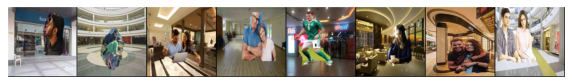

In [0]:
show(imgs, nrow=8)

In [0]:
class ConvGen(nn.Module):
  '''Generator'''
  def __init__(self):
    super(ConvGen,self).__init__()

    self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=32,kernel_size=(3,3),stride=1, 
                                              padding=1, bias= False),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU())
    self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=32,out_channels=32,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False,groups=32),
                                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(1,1),stride=1,
                                              padding=0,bias=False),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU())
    self.convblock3 = nn.Sequential(nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU())
    self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=256,out_channels=3,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))
    self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=3,out_channels=1,kernel_size=(3,3),stride=1,
                                              padding=1,bias=False))    

  def forward(self,sample):
    f1 = sample['f1']    
    f2 = sample['f2']

    f1 = self.convblock2(self.convblock1(f1))
    f2 = self.convblock2(self.convblock1(f2))

    f = torch.cat([f1,f2], dim=1)
    f = self.convblock5(self.convblock4(self.convblock3(f)))

    return f

In [0]:
#kernel_size = 3
#criterion = SSIM(kernel_size, reduction = 'mean)
criterion = nn.BCEWithLogitsLoss()

In [0]:
model    = ConvGen()
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)

ConvGen(
  (convblock1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (convblock3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock4): Sequential(
    (0): Conv2d(256, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (convblock5): Sequential(
    (0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )

In [0]:
from torchsummary import summary
summary(model, input_size=(3,192,192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 192, 192]             864
       BatchNorm2d-2         [-1, 32, 192, 192]              64
              ReLU-3         [-1, 32, 192, 192]               0
            Conv2d-4         [-1, 32, 192, 192]             288
            Conv2d-5         [-1, 64, 192, 192]           2,048
       BatchNorm2d-6         [-1, 64, 192, 192]             128
              ReLU-7         [-1, 64, 192, 192]               0
            Conv2d-8         [-1, 32, 192, 192]             864
       BatchNorm2d-9         [-1, 32, 192, 192]              64
             ReLU-10         [-1, 32, 192, 192]               0
           Conv2d-11         [-1, 32, 192, 192]             288
           Conv2d-12         [-1, 64, 192, 192]           2,048
      BatchNorm2d-13         [-1, 64, 192, 192]             128
             ReLU-14         [-1, 64, 1

In [0]:
optim = torch.optim.SGD(model.parameters(),lr=0.01, momentum = 0.9, weight_decay = 1e-5)

In [0]:
PATH = './saved_models/'
model = ConvGen()
model.load_state_dict(torch.load(PATH + '1000UsedOne.pth'))

In [0]:
PATH = Path('./saved_models/')
PATH.mkdir(exist_ok=True)

In [0]:
def train(model, criterion, device, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, data in enumerate(train_loader):
    data['f1'] = data['f1'].to(device)
    data['f2'] = data['f2'].to(device)
    data['f3'] = data['f3'].to(device)

    optimizer.zero_grad()
    output = model(data)

 # breakpoint()

    loss = criterion(output, data['f3'])   
    loss.backward()
    optimizer.step()
    if batch_idx % 24000 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))
      print('Batch ID:', batch_idx)

    if batch_idx % 24000 == 0:
      #show_pred(output.detach().cpu(), nrow =2) # nrow = sqrt-bs
      show(output.detach().cpu(),nrow = 8)   # nrow = sqrt-bs

    #if batch_idx % 500 == 0:  
    #  torch.save(model.state_dict(),PATH/f'{batch_idx}.pth')

In [0]:
def test(model, criterion, device, test_loader):
  model.eval()
  test_loss = 0
  #correct = 0
  with torch.no_grad():
    for data in test_loader:
      data['f1'] = data['f1'].to(device)
      data['f2'] = data['f2'].to(device)
      data['f3'] = data['f3'].to(device)
      output = model(data)

      test_loss = criterion(output, data['f3'], reduction='sum').item()  #sum up batch loss
      #pred = output.argmax(dim=1, keepdim = True) # get the index of max-log probability
      #correct += pred.eq(target.view_as(pred)).sum().item()

      show(output.cpu(), nrow=8) # nrow = sqrt-bs

  test_loss /= len(test_loader.dataset)

In [0]:
from torch.optim.lr_scheduler import StepLR

In [0]:
scheduler = StepLR(optim, step_size =1, gamma = 0.01)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/400000 (0%)]	Loss: 0.718992
Batch ID: 0


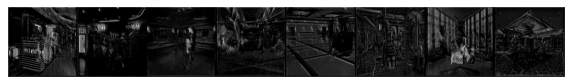

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [72000/400000 (48%)]	Loss: 0.716021
Batch ID: 24000


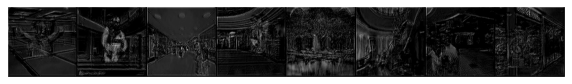

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [144000/400000 (96%)]	Loss: 0.706181
Batch ID: 48000


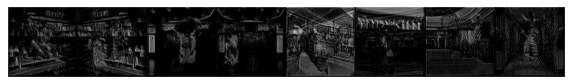

In [0]:
for epoch in range(1,2):
  train(model, criterion, model.device, train_dl, optim, epoch)
  #test(model, device, test_loader)
  scheduler.step()

In [0]:
#!cp '/content/FG_BG_Filename_withflip_Logs.txt' '/content/gdrive/My Drive/EVA4P1_S15/FG_BG_Mask_Depth/'